## Deforestation Prediction Models - Matale District

Predictive modeling to forecast future deforestation trends using multiple machine learning approaches:
- Time series forecasting (Prophet, ARIMA)
- Ensemble learning (Random Forest)
- Pattern discovery (K-Means clustering)
- Long-term projections (2026-2030)

DEFORESTATION PREDICTION MODELS - MATALE DISTRICT
Loading monthly data from: D:\Satellite Image Processing\Deforestation_Matale\Processed_Monthly\Monthly_Deforestation_Stats.csv
Loaded 246 monthly records (2013-05-26 → 2024-12-26)

Train/Test Split: 209 training, 37 testing records
Training period: 2013-05-26 to 2023-08-26
Testing period: 2023-09-19 to 2024-12-26

🟢 PROPHET MODEL - Time Series Forecasting


10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing


✓ Prophet Performance:
  MAE:  25.888 km²
  RMSE: 35.472 km²
  R²:   -0.643

🟡 ARIMA MODEL - Autoregressive Integrated Moving Average
✓ ARIMA(1,1,1) Performance:
  MAE:  21.626 km²
  RMSE: 28.365 km²
  R²:   -0.050

🟣 RANDOM FOREST MODEL - Ensemble Machine Learning
✓ Random Forest Performance:
  MAE:  15.651 km²
  RMSE: 25.233 km²
  R²:   0.169

  Feature Importance:
    Year: 0.481
    Month: 0.454
    Quarter: 0.065

⚪ K-MEANS CLUSTERING - Temporal Pattern Discovery
✓ Cluster Statistics:
               mean      min       max  count
Cluster                                      
0         14.111025   0.0000   34.6257    181
1        120.618847  89.8965  162.3321     17
2         56.339438  36.0045   87.7023     48


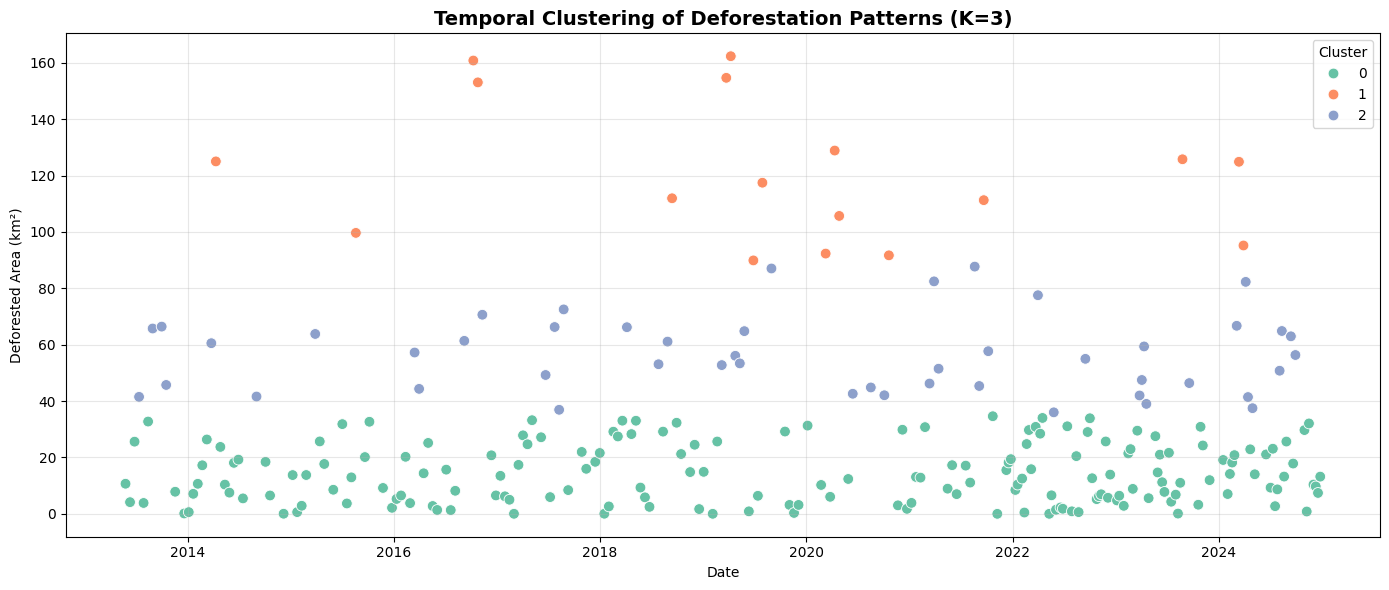

✓ Clustered data saved to: Deforestation_with_Clusters.csv

📊 MODEL COMPARISON SUMMARY
        Model  MAE (km²)  RMSE (km²)        R²
      Prophet  25.888055   35.471737 -0.642703
        ARIMA  21.626100   28.364654 -0.050387
Random Forest  15.650850   25.232885  0.168757

🏆 Best Performing Model: Random Forest (RMSE: 25.233 km²)

📈 GENERATING FORECAST VISUALIZATIONS


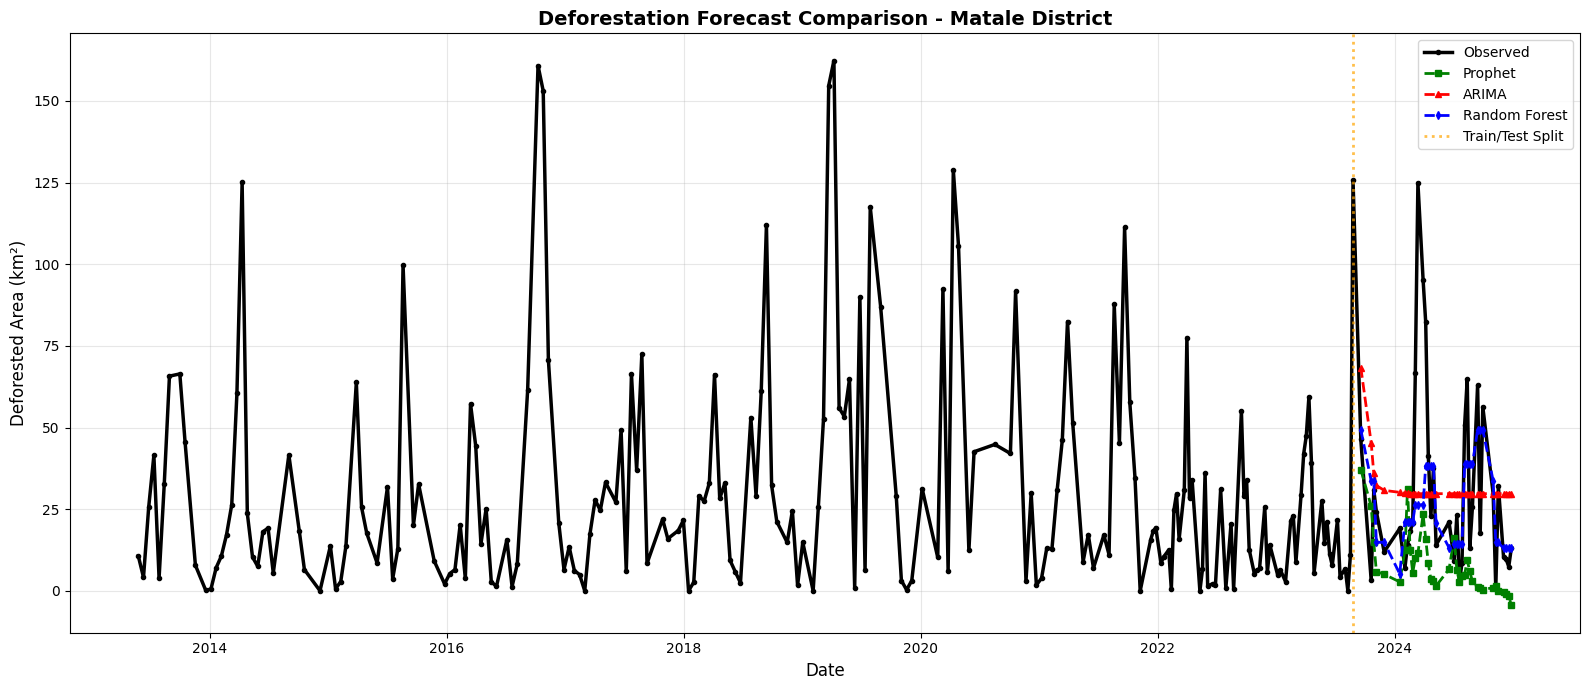

✓ Forecast comparison saved

🔮 GENERATING SHORT-TERM FUTURE PREDICTIONS


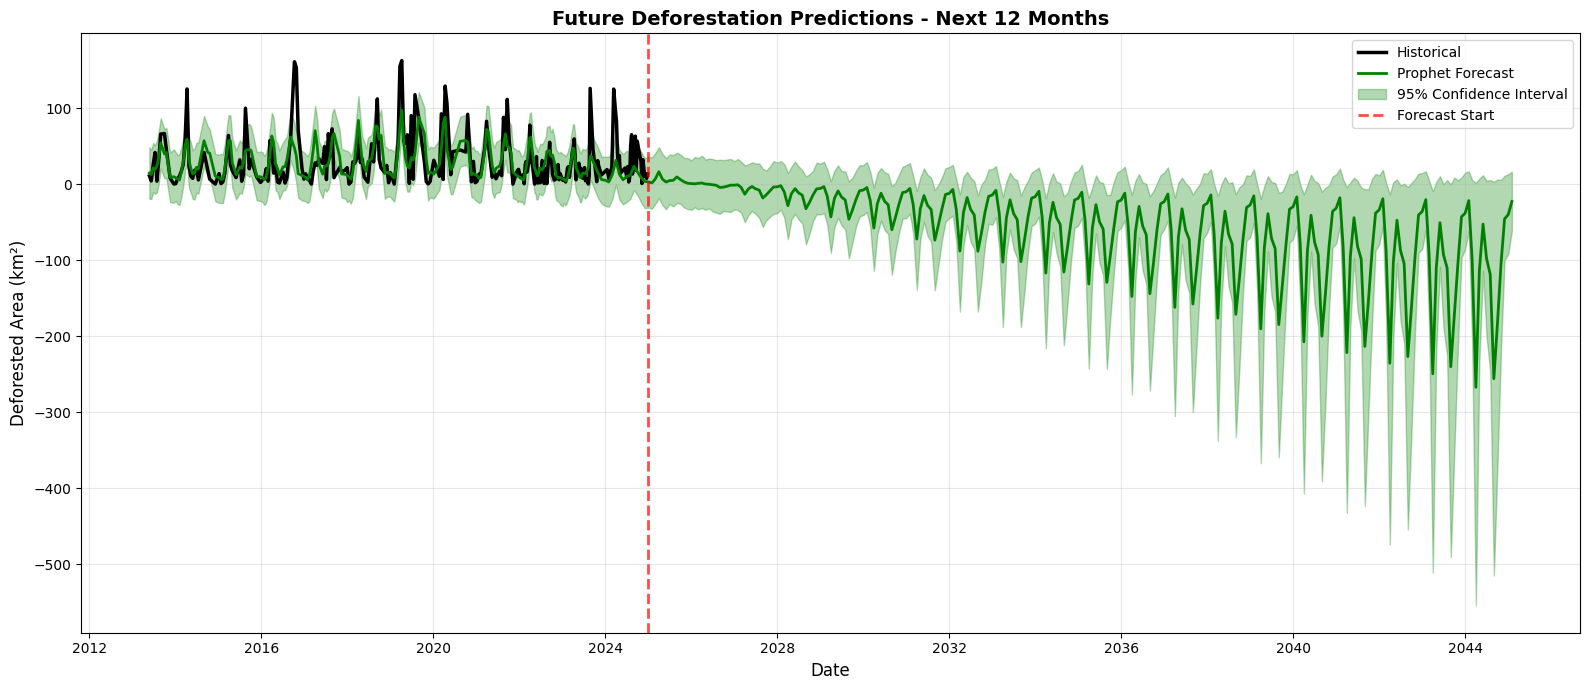

✓ Short-term predictions generated for next 12 months

✅ MODEL COMPARISON AND PREDICTION COMPLETE!
📁 Results saved to: D:\Satellite Image Processing\Deforestation_Matale\Model_Comparison

Generated files:
  • Model_Comparison_Results.csv - Performance metrics
  • KMeans_Temporal_Clusters.png - Clustering visualization
  • Model_Forecast_Comparison.png - Model comparison chart
  • Short_Term_Predictions.png - Future predictions
  • Deforestation_with_Clusters.csv - Data with cluster labels


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# CONFIGURATION
BASE_DIR = r"D:\Satellite Image Processing\Deforestation_Matale"
MONTHLY_FILE = os.path.join(BASE_DIR, "Processed_Monthly", "Monthly_Deforestation_Stats.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "Model_Comparison")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*70)
print("DEFORESTATION PREDICTION MODELS - MATALE DISTRICT")
print("="*70)

# LOAD DATA
def load_deforestation_data():
    """Load deforestation data"""
    
    if os.path.exists(MONTHLY_FILE):
        print(f"Loading monthly data from: {MONTHLY_FILE}")
        df = pd.read_csv(MONTHLY_FILE, parse_dates=["Date"])
        df = df.sort_values("Date")
        print(f"Loaded {len(df)} monthly records ({df['Date'].min().date()} → {df['Date'].max().date()})")
        return df, "monthly"
    else:
        raise FileNotFoundError(f"Data file not found: {MONTHLY_FILE}")

# Load data
df, data_type = load_deforestation_data()

# TRAIN/TEST SPLIT
train_size = int(len(df) * 0.85)
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]

y_train, y_test = train_df["Deforested_Area_km2"], test_df["Deforested_Area_km2"]
X_train_index, X_test_index = train_df["Date"], test_df["Date"]

print(f"\nTrain/Test Split: {len(train_df)} training, {len(test_df)} testing records")
print(f"Training period: {train_df['Date'].min().date()} to {train_df['Date'].max().date()}")
print(f"Testing period: {test_df['Date'].min().date()} to {test_df['Date'].max().date()}")

# 1. PROPHET MODEL
print("\n" + "="*70)
print("🟢 PROPHET MODEL - Time Series Forecasting")
print("="*70)

prophet_df = train_df[["Date", "Deforested_Area_km2"]].rename(columns={"Date": "ds", "Deforested_Area_km2": "y"})
model_prophet = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=0.3,
    seasonality_mode='multiplicative'
)
model_prophet.fit(prophet_df)

# Forecast
freq = "MS"  # Monthly start
future = model_prophet.make_future_dataframe(periods=len(test_df), freq=freq)
forecast = model_prophet.predict(future)
prophet_forecast = forecast.tail(len(test_df))
prophet_pred = prophet_forecast["yhat"].values

# Metrics
prophet_mae = mean_absolute_error(y_test, prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(y_test, prophet_pred))
prophet_r2 = r2_score(y_test, prophet_pred)

print(f"✓ Prophet Performance:")
print(f"  MAE:  {prophet_mae:.3f} km²")
print(f"  RMSE: {prophet_rmse:.3f} km²")
print(f"  R²:   {prophet_r2:.3f}")

# 2. ARIMA MODEL
print("\n" + "="*70)
print("🟡 ARIMA MODEL - Autoregressive Integrated Moving Average")
print("="*70)

try:
    arima_model = ARIMA(y_train, order=(1,1,1))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(y_test))
    
    arima_mae = mean_absolute_error(y_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))
    arima_r2 = r2_score(y_test, arima_forecast)
    
    print(f"✓ ARIMA(1,1,1) Performance:")
    print(f"  MAE:  {arima_mae:.3f} km²")
    print(f"  RMSE: {arima_rmse:.3f} km²")
    print(f"  R²:   {arima_r2:.3f}")
    
except Exception as e:
    print(f"⚠ ARIMA model failed: {str(e)}")
    # Fallback to moving average
    window = 12
    arima_forecast = np.full(len(y_test), y_train.rolling(window=window).mean().iloc[-1])
    arima_mae = mean_absolute_error(y_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))
    arima_r2 = r2_score(y_test, arima_forecast)
    print(f"✓ Moving Average (fallback) Performance:")
    print(f"  MAE:  {arima_mae:.3f} km²")
    print(f"  RMSE: {arima_rmse:.3f} km²")
    print(f"  R²:   {arima_r2:.3f}")

# 3. RANDOM FOREST MODEL
print("\n" + "="*70)
print("🟣 RANDOM FOREST MODEL - Ensemble Machine Learning")
print("="*70)

df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Quarter"] = df["Date"].dt.quarter
df["DayOfYear"] = df["Date"].dt.dayofyear

feature_cols = ["Month", "Year", "Quarter"]

X = df[feature_cols]
y = df["Deforested_Area_km2"]

X_train_rf, X_test_rf = X.iloc[:train_size], X.iloc[train_size:]
y_train_rf, y_test_rf = y.iloc[:train_size], y.iloc[train_size:]

rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
rf.fit(X_train_rf, y_train_rf)
rf_pred = rf.predict(X_test_rf)

rf_mae = mean_absolute_error(y_test_rf, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test_rf, rf_pred))
rf_r2 = r2_score(y_test_rf, rf_pred)

print(f"✓ Random Forest Performance:")
print(f"  MAE:  {rf_mae:.3f} km²")
print(f"  RMSE: {rf_rmse:.3f} km²")
print(f"  R²:   {rf_r2:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)
print(f"\n  Feature Importance:")
for _, row in feature_importance.iterrows():
    print(f"    {row['Feature']}: {row['Importance']:.3f}")

# 4. K-MEANS CLUSTERING
print("\n" + "="*70)
print("⚪ K-MEANS CLUSTERING - Temporal Pattern Discovery")
print("="*70)

X_scaled = StandardScaler().fit_transform(df[["Deforested_Area_km2"]])
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

cluster_stats = df.groupby('Cluster')['Deforested_Area_km2'].agg(['mean', 'min', 'max', 'count'])
print("✓ Cluster Statistics:")
print(cluster_stats)

plt.figure(figsize=(14,6))
sns.scatterplot(x="Date", y="Deforested_Area_km2", hue="Cluster", palette="Set2", data=df, s=60)
plt.title("Temporal Clustering of Deforestation Patterns (K=3)", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Deforested Area (km²)")
plt.grid(True, alpha=0.3)
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "KMeans_Temporal_Clusters.png"), dpi=200)
plt.show()

df.to_csv(os.path.join(OUTPUT_DIR, "Deforestation_with_Clusters.csv"), index=False)
print(f"✓ Clustered data saved to: Deforestation_with_Clusters.csv")

# 5. MODEL COMPARISON
print("\n" + "="*70)
print("📊 MODEL COMPARISON SUMMARY")
print("="*70)

results = pd.DataFrame({
    "Model": ["Prophet", "ARIMA", "Random Forest"],
    "MAE (km²)": [prophet_mae, arima_mae, rf_mae],
    "RMSE (km²)": [prophet_rmse, arima_rmse, rf_rmse],
    "R²": [prophet_r2, arima_r2, rf_r2]
})

print(results.to_string(index=False))

# Choose best model by RMSE
best_model = results.loc[results["RMSE (km²)"].idxmin(), "Model"]
best_rmse = results.loc[results["RMSE (km²)"].idxmin(), "RMSE (km²)"]
print(f"\n🏆 Best Performing Model: {best_model} (RMSE: {best_rmse:.3f} km²)")

results.to_csv(os.path.join(OUTPUT_DIR, "Model_Comparison_Results.csv"), index=False)

# 6. VISUALIZE FORECASTS
print("\n" + "="*70)
print("📈 GENERATING FORECAST VISUALIZATIONS")
print("="*70)

plt.figure(figsize=(16,7))
plt.plot(df["Date"], df["Deforested_Area_km2"], label="Observed", color="black", linewidth=2.5, marker='o', markersize=3)
plt.plot(X_test_index, prophet_pred, "g--", label="Prophet", linewidth=2, marker='s', markersize=4)
plt.plot(X_test_index, arima_forecast, "r--", label="ARIMA", linewidth=2, marker='^', markersize=4)
plt.plot(X_test_index, rf_pred, "b--", label="Random Forest", linewidth=2, marker='d', markersize=4)
plt.axvline(x=train_df['Date'].max(), color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Train/Test Split')
plt.title("Deforestation Forecast Comparison - Matale District", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Deforested Area (km²)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Model_Forecast_Comparison.png"), dpi=200)
plt.show()

print("✓ Forecast comparison saved")

# 7. FUTURE PREDICTIONS
print("\n" + "="*70)
print("🔮 GENERATING SHORT-TERM FUTURE PREDICTIONS")
print("="*70)

future_periods = 12  # 12 months ahead
future_df = model_prophet.make_future_dataframe(periods=len(df) + future_periods, freq=freq)
future_forecast = model_prophet.predict(future_df)

plt.figure(figsize=(16,7))
plt.plot(df["Date"], df["Deforested_Area_km2"], label="Historical", color="black", linewidth=2.5)
plt.plot(future_forecast["ds"], future_forecast["yhat"], "g-", label="Prophet Forecast", linewidth=2)
plt.fill_between(future_forecast["ds"], 
                future_forecast["yhat_lower"], 
                future_forecast["yhat_upper"], 
                alpha=0.3, color="green", label="95% Confidence Interval")
plt.axvline(x=df["Date"].max(), color="red", linestyle="--", linewidth=2, alpha=0.7, label="Forecast Start")
plt.title("Future Deforestation Predictions - Next 12 Months", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Deforested Area (km²)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Short_Term_Predictions.png"), dpi=200)
plt.show()

print(f"✓ Short-term predictions generated for next {future_periods} months")

print("\n" + "="*70)
print("✅ MODEL COMPARISON AND PREDICTION COMPLETE!")
print("="*70)
print(f"📁 Results saved to: {OUTPUT_DIR}")
print("\nGenerated files:")
print("  • Model_Comparison_Results.csv - Performance metrics")
print("  • KMeans_Temporal_Clusters.png - Clustering visualization")
print("  • Model_Forecast_Comparison.png - Model comparison chart")
print("  • Short_Term_Predictions.png - Future predictions")
print("  • Deforestation_with_Clusters.csv - Data with cluster labels")


🔮 LONG-TERM FORECAST (2026-2030) - PROPHET MODEL
📍 Projected Deforested Area in 2030: -11.18 km² (±35.51 km²)
   Date: 2030-12-01
   95% Confidence Interval: [-44.87, 24.33] km²


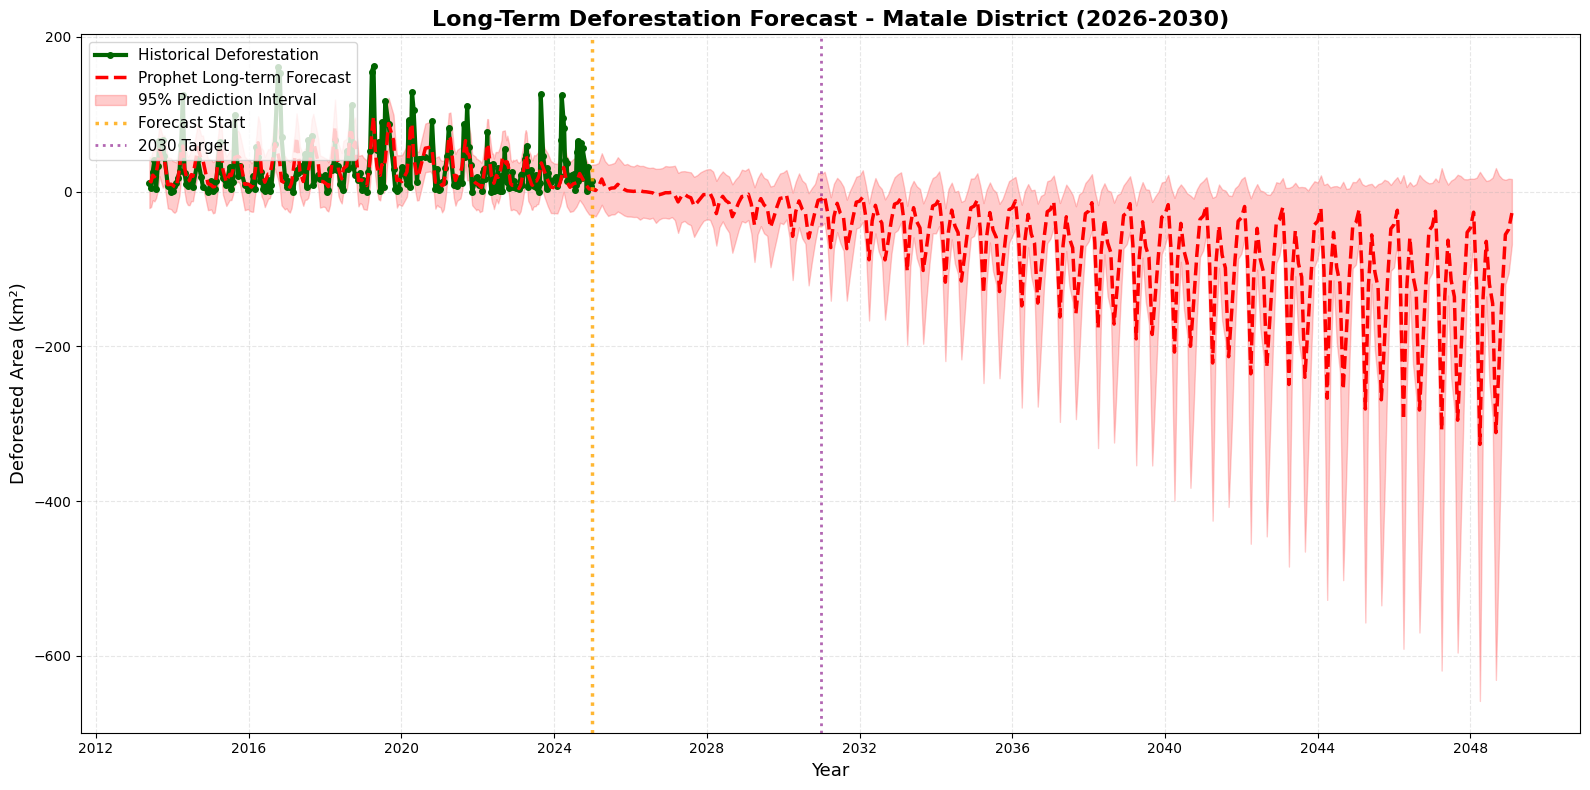

✓ Long-term forecast visualization saved
✓ Forecast data exported to: Deforestation_Forecast_2030.csv

✅ LONG-TERM FORECASTING COMPLETE
📈 All results saved to: D:\Satellite Image Processing\Deforestation_Matale\Model_Comparison

🌲 Use these forecasts to:
   • Plan forest conservation interventions
   • Identify high-risk deforestation zones
   • Set realistic reforestation targets
   • Monitor progress against projected trends


In [2]:
# LONG-TERM FUTURE PROJECTIONS (2026-2030)
print("\n" + "="*70)
print("🔮 LONG-TERM FORECAST (2026-2030) - PROPHET MODEL")
print("="*70)

# Extended prediction: 5 years ahead (60 months)
long_term_periods = 60
long_term_future = model_prophet.make_future_dataframe(periods=len(df) + long_term_periods, freq=freq)
long_term_forecast = model_prophet.predict(long_term_future)

# Extract future data only
future_only = long_term_forecast[long_term_forecast["ds"] > df["Date"].max()]

# Calculate 2030 projection
projection_2030 = future_only[future_only["ds"] <= "2030-12-31"]

if len(projection_2030) > 0:
    final_2030 = projection_2030.iloc[-1]
    print(f"📍 Projected Deforested Area in 2030: {final_2030['yhat']:.2f} km² (±{final_2030['yhat_upper'] - final_2030['yhat']:.2f} km²)")
    print(f"   Date: {final_2030['ds'].date()}")
    print(f"   95% Confidence Interval: [{final_2030['yhat_lower']:.2f}, {final_2030['yhat_upper']:.2f}] km²")

# VISUALIZATION
plt.figure(figsize=(16,8))

# Historical
plt.plot(df["Date"], df["Deforested_Area_km2"], 
         label="Historical Deforestation", 
         color="darkgreen", linewidth=3, marker='o', markersize=4)

# Long-term forecast
plt.plot(long_term_forecast["ds"], long_term_forecast["yhat"], 
         label="Prophet Long-term Forecast", 
         color="red", linewidth=2.5, linestyle='--')

plt.fill_between(long_term_forecast["ds"], 
                 long_term_forecast["yhat_lower"], 
                 long_term_forecast["yhat_upper"], 
                 alpha=0.2, color="red", label="95% Prediction Interval")

# Mark forecast start
plt.axvline(x=df["Date"].max(), color="orange", linestyle=":", linewidth=2.5, alpha=0.8, label="Forecast Start")

# Mark 2030
plt.axvline(x=pd.to_datetime("2030-12-31"), color="purple", linestyle=":", linewidth=2, alpha=0.6, label="2030 Target")

plt.title("Long-Term Deforestation Forecast - Matale District (2026-2030)", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=13)
plt.ylabel("Deforested Area (km²)", fontsize=13)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Deforestation_Forecast_2030.png"), dpi=200, bbox_inches='tight')
plt.show()

print("✓ Long-term forecast visualization saved")

# Save forecast data
forecast_export = long_term_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].rename(
    columns={"ds": "Date", "yhat": "Predicted_Deforested_Area_km2", 
             "yhat_lower": "Lower_Bound_km2", "yhat_upper": "Upper_Bound_km2"}
)
forecast_export.to_csv(os.path.join(OUTPUT_DIR, "Deforestation_Forecast_2030.csv"), index=False)

print("✓ Forecast data exported to: Deforestation_Forecast_2030.csv")

print("\n" + "="*70)
print("✅ LONG-TERM FORECASTING COMPLETE")
print("="*70)
print(f"📈 All results saved to: {OUTPUT_DIR}")
print("\n🌲 Use these forecasts to:")
print("   • Plan forest conservation interventions")
print("   • Identify high-risk deforestation zones")
print("   • Set realistic reforestation targets")
print("   • Monitor progress against projected trends")
print("="*70)